
# Setup

In [1]:
# for computing
import numpy as np
import xarray as xr # for reading/writing netcdf
import dask.array as da
import dask
import pandas as pd # only used for date times

# convenience things
from time import time, sleep
import os
import glob # for system commands
from natsort import natsorted # for alphabetical sorting

# for plotting
import matplotlib.pyplot as plt
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

In [2]:
# # contain worker logs in their own folder
# homedir = os.environ['HOME']
# daskpath=os.path.join(homedir, "dask-worker-space-can-be-deleted")

# try: 
#     os.mkdir(daskpath) 
# except OSError as error: 
#     print(error) 

[Errno 17] File exists: '/home/kerrie/dask-worker-space-can-be-deleted'


In [27]:
# link to where this notebook lives on github, same for everyone
nb_link='https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/global/01_dat_to_nc.ipynb'

# data directory location, same for everyoe
maskfile = 'ALOSmask5m_fill.rst'
# maskfile='mask_2268708_5m.nc'
static_dir = '/work/hpc/datasets/un_fao/gaez_v5/land/'
temp_dir = '/work/hpc/datasets/un_fao/gaez_v5_intermediate/'

source_dirs=['on MSU HPC2 /gri/projects/UN_FAO/',
             'on Orion /work/hpc/datasets/un_fao/gaez_v5_intermediate/dat/']

# file/variable info
year=2020#1980
fillval=-9999. # value used for missing in the dat files
experiment='Hist'

# scale and units info from the file "UnitScaleFactors.txt" from Gunther
varinfo={'Precip':{'scale_factor':1,
                   'units':'mm/month',
                   'long_name':'precipitation',
                   'description':'monthly total accumulated precipitation'},
         'Srad':{'scale_factor':1,
                 'units':'J/m2/day',
                 'long_name':'surface short wave radiation down',
                 'description':'monthly mean downwelling shortwave radiation at surface'},
         'Tmax-2m':{'scale_factor':1,
                    'units':'degrees C',
                    'long_name':'2m maximum surface air temperature',
                    'description':'monthly mean maximum surface air temperature at 2m'},
         'Tmin-2m':{'scale_factor':1,
                    'units':'degrees C',
                    'long_name':'2m minimum surface air temperature',
                    'description':'monthly mean minimum surface air temperature at 2m'},
         'Vapr':{'scale_factor':1,
                 'units':'hPa',
                 'long_name':'vapor pressure',
                 'description':'monthly mean vapor pressure'},
         'Wind-10m':{'scale_factor':1,
                     'units':'m/s',
                     'long_name':'10m wind speed',
                     'description':'monthly mean wind speed at 10m above surface'}}

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}

# encoding info for writing netcdf files
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
lat_encoding={'_FillValue':None}
lon_encoding={'_FillValue':None}
var_encoding = {'zlib':True,'dtype':'float32'}

# Read data from dat file

In [4]:
# choose a variable
varname='Srad'

In [5]:
# get dat file
infile=glob.glob(temp_dir+'dat/'+varname+'_AgERA5_'+experiment+'_'+str(year)+'_5m.dat')[0]
infile

'/work/hpc/datasets/un_fao/gaez_v5_intermediate/dat/Srad_AgERA5_Hist_2020_5m.dat'

In [6]:
# get each line from dat file as a string and remove carriage returns
temp=open(infile).read().splitlines() 

# grab the lines with lat/lons (every other line)
ilatilon=temp[0::2] 

# grab the lines with the data (every other line)
data=temp[1::2]

In [7]:
# get each string lat/lon as integer and put it in an numpy array
ilat=np.array([int(i.split()[0]) for i in ilatilon]).astype('int16') 
ilon=np.array([int(i.split()[1]) for i in ilatilon]).astype('int16') 

# put data in a numpy array too, takes 30-60s
data2D=np.loadtxt(data,dtype='float32')
nt=data2D.shape[1]

print('variable =',varname)
print('data dimensions:')
print(data2D.shape[0],'rows (each row represents a different grid cell)')
print(nt,'cols (each col represents a month of the year)')
print('data min max before scaling:',data2D.min(),data2D.max())

variable = Srad
data dimensions:
2295358 rows (each row represents a different grid cell)
12 cols (each col represents a month of the year)
data min max before scaling: -9999.0 38049144.0


In [8]:
# per Gunther, each monthly pxv file should have the following:
# 2268708 grids with data present
# 26650 grids equal to the fill value
# These two numbers combined equals the number of grids=1 in the ALOSmask (2295358)

# how many precip grids have data?  
nomissing=np.where(data2D==-9999,0,1)
ngrids=nomissing.sum()/nt

# how many grids are set to the missing value?
missing=np.where(data2D==-9999.,1,0)
nmissing=missing.sum()/nt

# print some info
print(ngrids,nmissing)
print(data2D.min(),data2D.max())

2268708.0 26650.0
-9999.0 38049144.0


# Get grid info from mask file

In [28]:
# get the lats and lons from the ALOSmask5m_fill.rst file
# mask=xr.open_dataset(static_dir+maskfile,engine='rasterio').squeeze()['band_data'] 
# mask=mask.drop('band')
# mask

mask=xr.open_dataset(temp_dir+'static/'+maskfile)
spatial_ref=mask.spatial_ref
spatial_ref

<xarray.DataArray 'band_data' (y: 2160, x: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int64 ...
Attributes:
    units:    unspecified

In [10]:
# save coordinate information for creating netcdf files
nlats,nlons=mask.mask.shape
lats=mask.mask.lat.data.astype('float32')
lons=mask.mask.lon.data.astype('float32')

# create a time dimension
time=pd.date_range(str(year)+'-01-01',str(year)+'-12-31',freq='MS')

# # if leap day is deleted out of the dataset, fix up time to match
# if len(time) != nt:
#     time=time[~(time==str(year)+'-02-29')]

print('global data dimensions:',nlats,'latitudes by',nlons,'longitudes by',nt,'months')

global data dimensions: 1800 latitudes by 4320 longitudes by 12 months


we now have the metadata needed (lat, lon, time info) to create an xarray data array to store global data

## Put data from dat file on a global grid

we process one latitude at a time to do this

In [11]:
# function for when data is present to put the data on a global grid
def build_full_lat(ixs,data,y,x,t):
    # create nan array of shape (all days, 1 lat, all lons)
    arr=np.empty((nt,len(y),len(x)),dtype='float32')
    arr[:]=np.nan    
    for i,ix in enumerate(ixs):
        arr[:,0,ix]=data[i,:]
    return arr#,arrda

# function for when no data is present at an entire latitude to create a latitude of nan
def build_empty_lat(y,x,t):
    # create nan array of shape (all days, 1 lat, all lons)   
    arr=np.empty((nt,len(y),len(x)),dtype='float32')
    arr[:]=np.nan
    return arr

In [12]:
# we process one latitude at a time
# and store each latitude of data in a list

arr_list=[]
for iy in range(nlats):
    if iy%500==0: print('processing iy = ',iy,'of',nlats)
    indices=np.where(ilat==iy+1)[0] # find which data rows apply to this latitude
    if np.any(indices):
        result=build_full_lat((ilon[indices]-1),data2D[indices,:],lats[iy:iy+1],lons,time)
        arr_list.append(result)
    else:
        result=build_empty_lat(lats[iy:iy+1],lons,time)     
        arr_list.append(result)

processing iy =  0 of 1800
processing iy =  500 of 1800
processing iy =  1000 of 1800
processing iy =  1500 of 1800


In [17]:
# concatenate the list of latitudes to get data on a global grid

bignp=np.concatenate(arr_list,axis=1,dtype='float32')
bignp.shape

(12, 1800, 4320)

In [18]:
# assign the grid metadata
bigarr=xr.DataArray(bignp,name=varname,
                 dims=['time','lat','lon'],
                 coords={'time':('time',time),'lat':('lat',lats),'lon':('lon',lons)}).astype('float32')

# bigarr=bigarr.where(mask.mask==1)#xr.where(mask==1,bigarr,np.nan) # .where reorders dimensions so we have to fix below
# replace the -9999 fill value with nan
bigarr=bigarr.where(bigarr!=fillval)  

# bigarr

In [22]:
# variable/coordinate metadata
varattrs={'standard_name':varname,
          'long_name':varinfo[varname]['long_name'],
          'units':varinfo[varname]['units'],
          'description':varinfo[varname]['description']}

# assign metadata
# bigarr.name=varname
bigarr.attrs=varattrs
bigarr['lat'].attrs=latattrs
bigarr['lon'].attrs=lonattrs
bigarr['time'].attrs=timeattrs

# array to dataset
ds=bigarr.to_dataset()
ds=ds.assign_coords({'spatial_ref':spatial_ref})
ds=ds.assign_attrs({'source_data':source_dirs,
                    'source_code':nb_link})

print('bigarr is',bigarr.nbytes/1E9,'GB')

ds

bigarr is 0.373248 GB


<xarray.Dataset>
Dimensions:      (time: 12, lat: 1800, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -59.79 -59.88 -59.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 ...
Data variables:
    Srad         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  ['on MSU HPC2 /gri/projects/UN_FAO/', 'on Orion /work/hpc/d...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

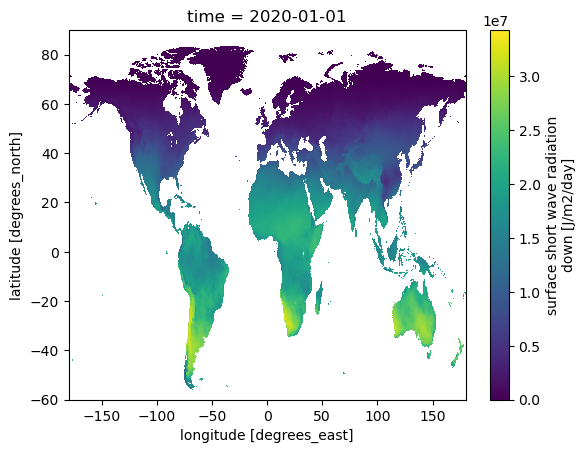

In [20]:
# visual check by plotting first month

ds[varname][0,:,:].plot()

# Write netcdf file with compression



In [23]:
# writing with compression
ds.to_netcdf(temp_dir+'netcdf/'+varname+'_Monthly_'+str(year)+'_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      varname:var_encoding})

#### process all other variables using the cells above, then proceed to below

# Check netcdf files

double checking that all files have 2287408 grids with data

In [25]:
files=glob.glob(temp_dir+'netcdf/'+'*_Monthly_'+str(year)+'_5m.nc')
files

['/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Tmin-2m_Monthly_2020_5m.nc',
 '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Precip_Monthly_2020_5m.nc',
 '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Wind-10m_Monthly_2020_5m.nc',
 '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Tmax-2m_Monthly_2020_5m.nc',
 '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Vapr_Monthly_2020_5m.nc',
 '/work/hpc/datasets/un_fao/gaez_v5_intermediate/netcdf/Srad_Monthly_2020_5m.nc']

In [26]:
for f in files:
    d=xr.open_dataset(f) # read a data file
    vn=list(d.keys())[0]  # get variable name
    d=np.where(np.isfinite(d[vn].isel(time=0)),1,0)  # select one timestep and create mask
    print(vn,'has',d.sum(),'grids with data')  # count how many grids have data

Tmin-2m has 2268708 grids with data
Precip has 2268708 grids with data
Wind-10m has 2268708 grids with data
Tmax-2m has 2268708 grids with data
Vapr has 2268708 grids with data
Srad has 2268708 grids with data
